# Definitions

In [1]:
from pathlib import Path
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
import category_encoders as ce
import optuna

In [2]:
data_path = Path('.', 'data')

In [3]:
RANDOM_STATE = 648

In [4]:
target_name = 'dep_delayed_15min'

# Data

In [5]:
train = pd.read_csv(data_path.joinpath('flight_delays_train.csv'))
test = pd.read_csv(data_path.joinpath('flight_delays_test.csv'))

In [6]:
train[target_name] = train[target_name].map({"Y": 1, "N": 0})

## Split Data

In [7]:
X, y = train.drop(target_name, axis=1), train[target_name]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# Preproc

## timestamp decoding

In [9]:
def get_ts(df):
    df['hour'] = df.DepTime // 100
    df['minute'] = df.DepTime % 100
    df['d_month'] = df.DayofMonth.str[2:].astype(int)
    df['d_week'] = df.DayOfWeek.str[2:].astype(int)
    df['month'] = df.Month.str[2:].astype(int)
    
    return df

## timestamp encoding

In [10]:
def ts_features(df):
    X_ = df[df.DepTime < 2400]
    dep_dt = pd.to_datetime('2021-' +
                                  X_.month.astype(str).str.zfill(2) + '-' +
                                  X_.d_month.astype(str).str.zfill(2) + '-' +
                                  X_.hour.astype(str).str.zfill(2) + '-' +
                                  X_.minute.astype(str).str.zfill(2) + '-00',
                                  format='%Y-%m-%d-%H-%M-%S')
    dep_td = dep_dt - pd.to_datetime('2021-01-01')
    df['days_since_ny'] = dep_td.dt.days
    df['secs_since_ny'] = dep_td.dt.seconds
    
    return df

## Category encoding

In [11]:
cat_cols = X_train.select_dtypes(include=[object, 'category']).columns

In [12]:
cat_cols

Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'], dtype='object')

### Target encoding

In [13]:
encoders_params = dict(cols=cat_cols,
                        handle_missing='return_nan',
                        handle_unknown='return_nan')

In [14]:
target_encoders = {'helmert': ce.HelmertEncoder(**encoders_params),
                   'js': ce.JamesSteinEncoder(**encoders_params),
                   'loo': ce.LeaveOneOutEncoder(**encoders_params),
                   'target': ce.TargetEncoder(**encoders_params),
                   'woe': ce.WOEEncoder(**encoders_params)}

In [15]:
enc = OrdinalEncoder(cols=cat_cols,
                     handle_missing='return_nan',
                     handle_unknown='return_nan')

In [16]:
%%time
enc.fit(X_train[cat_cols])
print('Done')

Done
CPU times: user 139 ms, sys: 20.1 ms, total: 159 ms
Wall time: 191 ms


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Sin/cos ts processing

In [17]:
t_limits = {'minute': (0, 59),
             'hour': (0, 23),
             'd_week': (1, 7),
             'd_month': (1, 31),
             'month': (1, 12),
             'days_since_ny': (0, 364)}

In [18]:
def sin_cos(df):
    for col_name, limits in t_limits.items():
        max_val = limits[1]
        min_val = limits[0]
        if col_name == 'hour':
            orig_vals = df[col_name].clip(upper=max_val)
        else:
            orig_vals = df[col_name]
        df[col_name + '_sin'] = np.sin(2*np.pi/(max_val - min_val)*orig_vals)
        df[col_name + '_cos'] = np.cos(2*np.pi/(max_val - min_val)*orig_vals)
        
    return df

## Sum up prepocessing

In [19]:
def preproc(df):
    df = get_ts(df)
    df = ts_features(df)
    df = sin_cos(df)
    
#     for name, encoder in target_encoders.items():
#         df[cat_cols + f'_{name}'] = encoder.transform(df[cat_cols])
    df[cat_cols] = enc.transform(df[cat_cols])
    df[cat_cols] = df[cat_cols].astype('category')
    
    # Special features
    df['after_midnight'] = 0
    df.loc[df.DepTime > 240, 'after_midnight'] = 1
    
    return df

In [20]:
%%time
X_train = preproc(X_train)
X_test = preproc(X_test)

<ipython-input-9-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-9-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-9-0555f0c157ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

CPU times: user 1.47 s, sys: 114 ms, total: 1.58 s
Wall time: 1.67 s


<ipython-input-10-6ca10571684d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_since_ny'] = dep_td.dt.days
<ipython-input-10-6ca10571684d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['secs_since_ny'] = dep_td.dt.seconds
<ipython-input-18-02630819fc8c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

# Fit

In [21]:
model = lgb.LGBMClassifier()

In [22]:
lgbm_params = {'boosting': 'gbdt',
               'bagging_fraction': 0.8,
               'bagging_freq': 10,
               'feature_fraction': 0.8,
               'learning_rate': 0.1,
               'max_depth': 10,
               'min_data_in_leaf': int(0.01*len(X_train)),
               'n_jobs': 8,
#                'num_leaves': 10,
               'n_estimators': 10_000,
               'reg_alpha': 5,
               'reg_lambda': 5,
               'random_state': RANDOM_STATE}

In [23]:
X_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute,...,hour_cos,d_week_sin,d_week_cos,d_month_sin,d_month_cos,month_sin,month_cos,days_since_ny_sin,days_since_ny_cos,after_midnight
46343,1.0,1.0,1.0,1805,1.0,1.0,1.0,1235,18,5,...,0.203456,8.660254e-01,0.5,-9.945219e-01,-0.104528,-9.898214e-01,-0.142315,-0.770953,-0.636892,1
75701,2.0,2.0,2.0,819,2.0,2.0,2.0,892,8,19,...,-0.576680,1.224647e-16,-1.0,1.224647e-16,-1.000000,9.096320e-01,0.415415,0.700978,0.713183,1
89227,3.0,3.0,2.0,726,3.0,3.0,3.0,200,7,26,...,-0.334880,1.224647e-16,-1.0,-5.877853e-01,-0.809017,-5.406408e-01,0.841254,-0.957253,0.289252,1
70825,4.0,4.0,3.0,1515,1.0,4.0,4.0,403,15,15,...,-0.576680,8.660254e-01,0.5,8.660254e-01,-0.500000,7.557496e-01,-0.654861,0.990480,-0.137654,1
26022,5.0,5.0,4.0,1453,4.0,5.0,5.0,94,14,53,...,-0.775711,-8.660254e-01,0.5,-9.510565e-01,0.309017,-2.449294e-16,1.000000,-0.596132,0.802886,1


In [24]:
model.set_params(**lgbm_params)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting='gbdt',
               feature_fraction=0.8, max_depth=10, min_data_in_leaf=700,
               n_estimators=10000, n_jobs=8, random_state=648, reg_alpha=5,
               reg_lambda=5)

In [25]:
X_tr, X_es, y_tr, y_es = train_test_split(X_train, y_train,
                                          test_size=0.1,
                                          shuffle=True,
                                          random_state=RANDOM_STATE)

In [26]:
%%time
model.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_es, y_es)],
          eval_metric=['auc'],
          early_stopping_rounds=50)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	training's auc: 0.716656	training's binary_logloss: 0.479923	valid_1's auc: 0.692579	valid_1's binary_logloss: 0.478211
Training until validation scores don't improve for 50 rounds
[2]	training's auc: 0.727056	training's binary_logloss: 0.472899	valid_1's auc: 0.70214	valid_1's binary_logloss: 0.472052
[3]	training's auc: 0.731033	training's binary_logloss: 0.466707	valid_1's auc: 0.707762	valid_1's binary_logloss: 0.466567
[4]	training's auc: 0.734859	training's binary_logloss: 0.461411	valid_1's auc: 0.711258	valid_1's binary_logloss: 0.461988
[5]	training's auc: 0.738869	training's binary_logloss: 0.456748	valid_1's auc: 0.715236	valid_1's binary_logloss: 0.458031
[6]	training's auc: 0.741034	training's binary_logloss: 0.452957	valid_1's auc: 0.717001	valid_1's binary_logloss: 0.454768
[7]	training's auc: 0.74334	training's binary_logloss: 0.449328	valid_1's auc: 0.718686	valid_1's binary_logloss: 0.451857
[8]	training's auc: 0.744321	training's binary_logloss: 0.446368	valid_1'

[73]	training's auc: 0.833908	training's binary_logloss: 0.377608	valid_1's auc: 0.731819	valid_1's binary_logloss: 0.429548
[74]	training's auc: 0.834836	training's binary_logloss: 0.377006	valid_1's auc: 0.732212	valid_1's binary_logloss: 0.429389
[75]	training's auc: 0.835773	training's binary_logloss: 0.376426	valid_1's auc: 0.731772	valid_1's binary_logloss: 0.42958
[76]	training's auc: 0.836642	training's binary_logloss: 0.375872	valid_1's auc: 0.731684	valid_1's binary_logloss: 0.429658
[77]	training's auc: 0.837072	training's binary_logloss: 0.375429	valid_1's auc: 0.731943	valid_1's binary_logloss: 0.429507
[78]	training's auc: 0.83758	training's binary_logloss: 0.374928	valid_1's auc: 0.732305	valid_1's binary_logloss: 0.429316
[79]	training's auc: 0.838283	training's binary_logloss: 0.374398	valid_1's auc: 0.732598	valid_1's binary_logloss: 0.4292
[80]	training's auc: 0.83913	training's binary_logloss: 0.373835	valid_1's auc: 0.732012	valid_1's binary_logloss: 0.42947
[81]	t

LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting='gbdt',
               feature_fraction=0.8, max_depth=10, min_data_in_leaf=700,
               n_estimators=10000, n_jobs=8, random_state=648, reg_alpha=5,
               reg_lambda=5)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

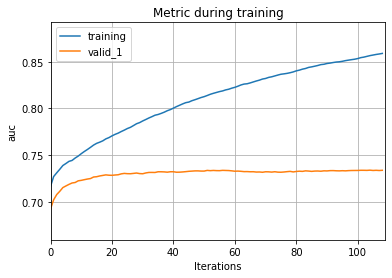

In [27]:
lgb.plot_metric(model, metric='auc')

In [28]:
fi = pd.Series(model.feature_importances_, index=X_tr.columns)

In [29]:
with pd.option_context('display.max_rows', None):
    display(fi.sort_values(ascending=False))

Dest                 483
Origin               428
DayofMonth           312
UniqueCarrier        116
Month                 90
DepTime               57
hour_sin              50
days_since_ny_sin     32
DayOfWeek             31
secs_since_ny         26
hour_cos              26
days_since_ny_cos     24
days_since_ny         22
minute_cos            15
d_week_sin            15
Distance              10
minute_sin             9
d_week                 6
minute                 5
d_month                4
d_month_sin            2
hour                   1
d_week_cos             1
month_sin              1
month                  0
d_month_cos            0
month_cos              0
after_midnight         0
dtype: int32

# Validate

In [30]:
def get_proba(X):
    proba = model.predict_proba(X)[:, 1]
#     proba[X.DepTime > 2400] = 1.
    return proba

In [31]:
tr_proba = get_proba(X_tr)

In [32]:
roc_auc_score(y_tr, get_proba(X_tr))

0.8205988962071462

In [33]:
roc_auc_score(y_train, get_proba(X_train))

0.8120673490637935

In [34]:
roc_auc_score(y_test, get_proba(X_test))

0.7332721993239084

# Optuna

## Prepare folds

In [35]:
cv_splitter = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE)

In [36]:
train_ds = []
test_ds = []
for train_ind, test_ind in cv_splitter.split(X, y):
    X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
    X_test, y_test = X.iloc[test_ind], y.iloc[test_ind]

#     enc = OrdinalEncoder(cols=cat_cols,
#                          handle_missing='return_nan',
#                          handle_unknown='return_nan')
#     for name, encoder in target_encoders.items()
#         X_train[cat_cols + f'_{name}'] = encoder.fit(X_train[cat_cols])
    enc.fit(X_train[cat_cols])

    X_train = preproc(X_train)
    X_test = preproc(X_test)
    
    train_ds.append((X_train, y_train))
    test_ds.append((X_test, y_test))

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
<ipython-input-9-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-9-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-9-0555f0c157ea>:4: Set

<ipython-input-9-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-9-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-9-0555f0c157ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

<ipython-input-9-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-9-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-9-0555f0c157ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

<ipython-input-9-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-9-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-9-0555f0c157ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

<ipython-input-9-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-9-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-9-0555f0c157ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [37]:
X.shape

(100000, 8)

In [38]:
def objective(trial):
    lgbm_params = {'boosting': 'gbdt',
                   'bagging_fraction': trial.suggest_float("bagging_fraction",
                                                           0.5, 1.0),
                   'bagging_freq': 1,
                   'feature_fraction': trial.suggest_float("feature_fraction",
                                                           0.5, 1.0),
                   'learning_rate': trial.suggest_float("lr",
                                                        0.0001, 0.5),
                   'max_depth': trial.suggest_int("max_depth", 1, 15),
                   'min_data_in_leaf': trial.suggest_int("min_data_in_leaf",
                                                         1,
                                                         10000, log=True),
                   'n_estimators': 10_000,
                   'reg_alpha': trial.suggest_float("reg_alpha", 0, 10),
                   'reg_lambda': trial.suggest_float("reg_lambda", 0, 10),
                   'random_state': RANDOM_STATE,
                   'silent': True}

    metrics = []
    cv_splitter = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE)
    for train_set, test_set in zip(train_ds, test_ds):
        X_train, y_train = train_set
        X_test, y_test = test_set

        X_tr, X_es, y_tr, y_es = train_test_split(X_train, y_train,
                                                  test_size=0.1,
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)
        model = lgb.LGBMClassifier()
        model.set_params(**lgbm_params)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_es, y_es)],
                  eval_metric=['auc'],
                  early_stopping_rounds=50,
                  verbose=0)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        metrics.append(auc)
    return sum(metrics) / 5

In [39]:
%%time
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

trial = study.best_trial

pickle.dump(study, open('optuna_study.pkl', 'wb'))

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.7969356545543405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7969356545543405
[LightGBM] [Warning] bagging_fraction is set=0.7081899111825327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7081899111825327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.7969356545543405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7969356545543405
[LightGBM] [Warning] bagging_fraction is set=0.7081899111825327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7081899111825327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.7969356545543405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7969356545543405
[LightGBM] [Warning] bagging_fraction is set=0.7081899111825327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7081899111825327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.7969356545543405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7969356545543405
[LightGBM] [Warning] bagging_fraction is set=0.7081899111825327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7081899111825327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.7969356545543405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7969356545543405
[LightGBM] [Warning] bagging_fraction is set=0.7081899111825327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7081899111825327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1835, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1835
[LightGBM] [Warning] feature_fraction is set=0.7320600264463235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7320600264463235
[LightGBM] [Warning] bagging_fraction is set=0.7056262515412697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7056262515412697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1835, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1835
[LightGBM] [Warning] feature_fraction is set=0.7320600264463235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7320600264463235
[LightGBM] [Warning] bagging_fraction is set=0.7056262515412697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7056262515412697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1835, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1835
[LightGBM] [Warning] feature_fraction is set=0.7320600264463235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7320600264463235
[LightGBM] [Warning] bagging_fraction is set=0.7056262515412697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7056262515412697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1835, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1835
[LightGBM] [Warning] feature_fraction is set=0.7320600264463235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7320600264463235
[LightGBM] [Warning] bagging_fraction is set=0.7056262515412697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7056262515412697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1835, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1835
[LightGBM] [Warning] feature_fraction is set=0.7320600264463235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7320600264463235
[LightGBM] [Warning] bagging_fraction is set=0.7056262515412697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7056262515412697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.8080793508377673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8080793508377673
[LightGBM] [Warning] bagging_fraction is set=0.5863974560987526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5863974560987526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.8080793508377673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8080793508377673
[LightGBM] [Warning] bagging_fraction is set=0.5863974560987526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5863974560987526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.8080793508377673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8080793508377673
[LightGBM] [Warning] bagging_fraction is set=0.5863974560987526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5863974560987526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.8080793508377673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8080793508377673
[LightGBM] [Warning] bagging_fraction is set=0.5863974560987526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5863974560987526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.8080793508377673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8080793508377673
[LightGBM] [Warning] bagging_fraction is set=0.5863974560987526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5863974560987526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=159
[LightGBM] [Warning] feature_fraction is set=0.9907079848743698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9907079848743698
[LightGBM] [Warning] bagging_fraction is set=0.5393469409039287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5393469409039287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=159
[LightGBM] [Warning] feature_fraction is set=0.9907079848743698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9907079848743698
[LightGBM] [Warning] bagging_fraction is set=0.5393469409039287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5393469409039287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=159
[LightGBM] [Warning] feature_fraction is set=0.9907079848743698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9907079848743698
[LightGBM] [Warning] bagging_fraction is set=0.5393469409039287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5393469409039287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=159
[LightGBM] [Warning] feature_fraction is set=0.9907079848743698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9907079848743698
[LightGBM] [Warning] bagging_fraction is set=0.5393469409039287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5393469409039287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=159
[LightGBM] [Warning] feature_fraction is set=0.9907079848743698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9907079848743698
[LightGBM] [Warning] bagging_fraction is set=0.5393469409039287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5393469409039287
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.7342902038825487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7342902038825487
[LightGBM] [Warning] bagging_fraction is set=0.9920398672268166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9920398672268166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.7342902038825487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7342902038825487
[LightGBM] [Warning] bagging_fraction is set=0.9920398672268166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9920398672268166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.7342902038825487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7342902038825487
[LightGBM] [Warning] bagging_fraction is set=0.9920398672268166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9920398672268166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.7342902038825487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7342902038825487
[LightGBM] [Warning] bagging_fraction is set=0.9920398672268166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9920398672268166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.7342902038825487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7342902038825487
[LightGBM] [Warning] bagging_fraction is set=0.9920398672268166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9920398672268166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.630881214496823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.630881214496823
[LightGBM] [Warning] bagging_fraction is set=0.9867913671314745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867913671314745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.630881214496823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.630881214496823
[LightGBM] [Warning] bagging_fraction is set=0.9867913671314745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867913671314745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.630881214496823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.630881214496823
[LightGBM] [Warning] bagging_fraction is set=0.9867913671314745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867913671314745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.630881214496823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.630881214496823
[LightGBM] [Warning] bagging_fraction is set=0.9867913671314745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867913671314745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.630881214496823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.630881214496823
[LightGBM] [Warning] bagging_fraction is set=0.9867913671314745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867913671314745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1254, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1254
[LightGBM] [Warning] feature_fraction is set=0.9905355372238946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9905355372238946
[LightGBM] [Warning] bagging_fraction is set=0.5348093719798286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5348093719798286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1254, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1254
[LightGBM] [Warning] feature_fraction is set=0.9905355372238946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9905355372238946
[LightGBM] [Warning] bagging_fraction is set=0.5348093719798286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5348093719798286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1254, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1254
[LightGBM] [Warning] feature_fraction is set=0.9905355372238946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9905355372238946
[LightGBM] [Warning] bagging_fraction is set=0.5348093719798286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5348093719798286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1254, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1254
[LightGBM] [Warning] feature_fraction is set=0.9905355372238946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9905355372238946
[LightGBM] [Warning] bagging_fraction is set=0.5348093719798286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5348093719798286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1254, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1254
[LightGBM] [Warning] feature_fraction is set=0.9905355372238946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9905355372238946
[LightGBM] [Warning] bagging_fraction is set=0.5348093719798286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5348093719798286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9655, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9655
[LightGBM] [Warning] feature_fraction is set=0.7483074632666789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7483074632666789
[LightGBM] [Warning] bagging_fraction is set=0.7751763951807484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751763951807484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9655, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9655
[LightGBM] [Warning] feature_fraction is set=0.7483074632666789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7483074632666789
[LightGBM] [Warning] bagging_fraction is set=0.7751763951807484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751763951807484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9655, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9655
[LightGBM] [Warning] feature_fraction is set=0.7483074632666789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7483074632666789
[LightGBM] [Warning] bagging_fraction is set=0.7751763951807484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751763951807484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9655, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9655
[LightGBM] [Warning] feature_fraction is set=0.7483074632666789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7483074632666789
[LightGBM] [Warning] bagging_fraction is set=0.7751763951807484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751763951807484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9655, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9655
[LightGBM] [Warning] feature_fraction is set=0.7483074632666789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7483074632666789
[LightGBM] [Warning] bagging_fraction is set=0.7751763951807484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751763951807484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.9482797043622011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9482797043622011
[LightGBM] [Warning] bagging_fraction is set=0.6192476180363649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6192476180363649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.9482797043622011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9482797043622011
[LightGBM] [Warning] bagging_fraction is set=0.6192476180363649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6192476180363649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.9482797043622011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9482797043622011
[LightGBM] [Warning] bagging_fraction is set=0.6192476180363649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6192476180363649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.9482797043622011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9482797043622011
[LightGBM] [Warning] bagging_fraction is set=0.6192476180363649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6192476180363649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.9482797043622011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9482797043622011
[LightGBM] [Warning] bagging_fraction is set=0.6192476180363649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6192476180363649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=372, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=372
[LightGBM] [Warning] feature_fraction is set=0.6141699639635625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6141699639635625
[LightGBM] [Warning] bagging_fraction is set=0.9892225754534116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9892225754534116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=372, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=372
[LightGBM] [Warning] feature_fraction is set=0.6141699639635625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6141699639635625
[LightGBM] [Warning] bagging_fraction is set=0.9892225754534116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9892225754534116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=372, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=372
[LightGBM] [Warning] feature_fraction is set=0.6141699639635625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6141699639635625
[LightGBM] [Warning] bagging_fraction is set=0.9892225754534116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9892225754534116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=372, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=372
[LightGBM] [Warning] feature_fraction is set=0.6141699639635625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6141699639635625
[LightGBM] [Warning] bagging_fraction is set=0.9892225754534116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9892225754534116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=372, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=372
[LightGBM] [Warning] feature_fraction is set=0.6141699639635625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6141699639635625
[LightGBM] [Warning] bagging_fraction is set=0.9892225754534116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9892225754534116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5227322517285872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227322517285872
[LightGBM] [Warning] bagging_fraction is set=0.8602149995470094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8602149995470094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5227322517285872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227322517285872
[LightGBM] [Warning] bagging_fraction is set=0.8602149995470094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8602149995470094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5227322517285872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227322517285872
[LightGBM] [Warning] bagging_fraction is set=0.8602149995470094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8602149995470094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5227322517285872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227322517285872
[LightGBM] [Warning] bagging_fraction is set=0.8602149995470094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8602149995470094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5227322517285872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227322517285872
[LightGBM] [Warning] bagging_fraction is set=0.8602149995470094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8602149995470094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5058622737313475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5058622737313475
[LightGBM] [Warning] bagging_fraction is set=0.8858019257453144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8858019257453144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5058622737313475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5058622737313475
[LightGBM] [Warning] bagging_fraction is set=0.8858019257453144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8858019257453144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5058622737313475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5058622737313475
[LightGBM] [Warning] bagging_fraction is set=0.8858019257453144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8858019257453144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5058622737313475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5058622737313475
[LightGBM] [Warning] bagging_fraction is set=0.8858019257453144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8858019257453144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5058622737313475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5058622737313475
[LightGBM] [Warning] bagging_fraction is set=0.8858019257453144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8858019257453144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5141369899174939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5141369899174939
[LightGBM] [Warning] bagging_fraction is set=0.9013428890099264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9013428890099264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5141369899174939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5141369899174939
[LightGBM] [Warning] bagging_fraction is set=0.9013428890099264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9013428890099264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5141369899174939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5141369899174939
[LightGBM] [Warning] bagging_fraction is set=0.9013428890099264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9013428890099264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5141369899174939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5141369899174939
[LightGBM] [Warning] bagging_fraction is set=0.9013428890099264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9013428890099264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.5141369899174939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5141369899174939
[LightGBM] [Warning] bagging_fraction is set=0.9013428890099264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9013428890099264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.6135139569203152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6135139569203152
[LightGBM] [Warning] bagging_fraction is set=0.904118860322118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.904118860322118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.6135139569203152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6135139569203152
[LightGBM] [Warning] bagging_fraction is set=0.904118860322118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.904118860322118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.6135139569203152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6135139569203152
[LightGBM] [Warning] bagging_fraction is set=0.904118860322118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.904118860322118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.6135139569203152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6135139569203152
[LightGBM] [Warning] bagging_fraction is set=0.904118860322118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.904118860322118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.6135139569203152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6135139569203152
[LightGBM] [Warning] bagging_fraction is set=0.904118860322118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.904118860322118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] feature_fraction is set=0.6057235454828396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6057235454828396
[LightGBM] [Warning] bagging_fraction is set=0.8365058104682259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8365058104682259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] feature_fraction is set=0.6057235454828396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6057235454828396
[LightGBM] [Warning] bagging_fraction is set=0.8365058104682259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8365058104682259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] feature_fraction is set=0.6057235454828396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6057235454828396
[LightGBM] [Warning] bagging_fraction is set=0.8365058104682259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8365058104682259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] feature_fraction is set=0.6057235454828396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6057235454828396
[LightGBM] [Warning] bagging_fraction is set=0.8365058104682259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8365058104682259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] feature_fraction is set=0.6057235454828396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6057235454828396
[LightGBM] [Warning] bagging_fraction is set=0.8365058104682259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8365058104682259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.615764232472012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.615764232472012
[LightGBM] [Warning] bagging_fraction is set=0.8082416707201303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082416707201303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.615764232472012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.615764232472012
[LightGBM] [Warning] bagging_fraction is set=0.8082416707201303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082416707201303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.615764232472012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.615764232472012
[LightGBM] [Warning] bagging_fraction is set=0.8082416707201303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082416707201303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.615764232472012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.615764232472012
[LightGBM] [Warning] bagging_fraction is set=0.8082416707201303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082416707201303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.615764232472012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.615764232472012
[LightGBM] [Warning] bagging_fraction is set=0.8082416707201303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082416707201303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=580, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=580
[LightGBM] [Warning] feature_fraction is set=0.6687247495204733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6687247495204733
[LightGBM] [Warning] bagging_fraction is set=0.9544226769742272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9544226769742272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=580, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=580
[LightGBM] [Warning] feature_fraction is set=0.6687247495204733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6687247495204733
[LightGBM] [Warning] bagging_fraction is set=0.9544226769742272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9544226769742272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=580, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=580
[LightGBM] [Warning] feature_fraction is set=0.6687247495204733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6687247495204733
[LightGBM] [Warning] bagging_fraction is set=0.9544226769742272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9544226769742272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=580, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=580
[LightGBM] [Warning] feature_fraction is set=0.6687247495204733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6687247495204733
[LightGBM] [Warning] bagging_fraction is set=0.9544226769742272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9544226769742272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=580, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=580
[LightGBM] [Warning] feature_fraction is set=0.6687247495204733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6687247495204733
[LightGBM] [Warning] bagging_fraction is set=0.9544226769742272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9544226769742272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5580727643720629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5580727643720629
[LightGBM] [Warning] bagging_fraction is set=0.8335169013226771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8335169013226771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5580727643720629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5580727643720629
[LightGBM] [Warning] bagging_fraction is set=0.8335169013226771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8335169013226771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5580727643720629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5580727643720629
[LightGBM] [Warning] bagging_fraction is set=0.8335169013226771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8335169013226771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5580727643720629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5580727643720629
[LightGBM] [Warning] bagging_fraction is set=0.8335169013226771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8335169013226771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5580727643720629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5580727643720629
[LightGBM] [Warning] bagging_fraction is set=0.8335169013226771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8335169013226771
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5560354330577798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5560354330577798
[LightGBM] [Warning] bagging_fraction is set=0.9408615326665672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9408615326665672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5560354330577798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5560354330577798
[LightGBM] [Warning] bagging_fraction is set=0.9408615326665672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9408615326665672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5560354330577798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5560354330577798
[LightGBM] [Warning] bagging_fraction is set=0.9408615326665672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9408615326665672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5560354330577798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5560354330577798
[LightGBM] [Warning] bagging_fraction is set=0.9408615326665672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9408615326665672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5560354330577798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5560354330577798
[LightGBM] [Warning] bagging_fraction is set=0.9408615326665672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9408615326665672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=266, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=266
[LightGBM] [Warning] feature_fraction is set=0.6938606182423659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6938606182423659
[LightGBM] [Warning] bagging_fraction is set=0.7331442262349721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7331442262349721
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=266, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=266
[LightGBM] [Warning] feature_fraction is set=0.6938606182423659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6938606182423659
[LightGBM] [Warning] bagging_fraction is set=0.7331442262349721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7331442262349721
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=266, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=266
[LightGBM] [Warning] feature_fraction is set=0.6938606182423659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6938606182423659
[LightGBM] [Warning] bagging_fraction is set=0.7331442262349721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7331442262349721
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=266, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=266
[LightGBM] [Warning] feature_fraction is set=0.6938606182423659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6938606182423659
[LightGBM] [Warning] bagging_fraction is set=0.7331442262349721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7331442262349721
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=266, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=266
[LightGBM] [Warning] feature_fraction is set=0.6938606182423659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6938606182423659
[LightGBM] [Warning] bagging_fraction is set=0.7331442262349721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7331442262349721
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.6633568505983382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6633568505983382
[LightGBM] [Warning] bagging_fraction is set=0.7891954814657426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7891954814657426
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.6633568505983382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6633568505983382
[LightGBM] [Warning] bagging_fraction is set=0.7891954814657426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7891954814657426
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.6633568505983382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6633568505983382
[LightGBM] [Warning] bagging_fraction is set=0.7891954814657426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7891954814657426
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.6633568505983382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6633568505983382
[LightGBM] [Warning] bagging_fraction is set=0.7891954814657426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7891954814657426
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.6633568505983382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6633568505983382
[LightGBM] [Warning] bagging_fraction is set=0.7891954814657426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7891954814657426
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5596118999462426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5596118999462426
[LightGBM] [Warning] bagging_fraction is set=0.8285713393145968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8285713393145968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5596118999462426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5596118999462426
[LightGBM] [Warning] bagging_fraction is set=0.8285713393145968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8285713393145968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5596118999462426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5596118999462426
[LightGBM] [Warning] bagging_fraction is set=0.8285713393145968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8285713393145968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5596118999462426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5596118999462426
[LightGBM] [Warning] bagging_fraction is set=0.8285713393145968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8285713393145968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.5596118999462426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5596118999462426
[LightGBM] [Warning] bagging_fraction is set=0.8285713393145968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8285713393145968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.5652447705300956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5652447705300956
[LightGBM] [Warning] bagging_fraction is set=0.825970140418906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.825970140418906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.5652447705300956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5652447705300956
[LightGBM] [Warning] bagging_fraction is set=0.825970140418906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.825970140418906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.5652447705300956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5652447705300956
[LightGBM] [Warning] bagging_fraction is set=0.825970140418906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.825970140418906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.5652447705300956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5652447705300956
[LightGBM] [Warning] bagging_fraction is set=0.825970140418906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.825970140418906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.5652447705300956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5652447705300956
[LightGBM] [Warning] bagging_fraction is set=0.825970140418906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.825970140418906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5597780676653162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597780676653162
[LightGBM] [Warning] bagging_fraction is set=0.6571681712344277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6571681712344277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5597780676653162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597780676653162
[LightGBM] [Warning] bagging_fraction is set=0.6571681712344277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6571681712344277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5597780676653162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597780676653162
[LightGBM] [Warning] bagging_fraction is set=0.6571681712344277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6571681712344277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5597780676653162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597780676653162
[LightGBM] [Warning] bagging_fraction is set=0.6571681712344277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6571681712344277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5597780676653162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597780676653162
[LightGBM] [Warning] bagging_fraction is set=0.6571681712344277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6571681712344277
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.5495710869799668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5495710869799668
[LightGBM] [Warning] bagging_fraction is set=0.7671509231458118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7671509231458118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.5495710869799668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5495710869799668
[LightGBM] [Warning] bagging_fraction is set=0.7671509231458118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7671509231458118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.5495710869799668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5495710869799668
[LightGBM] [Warning] bagging_fraction is set=0.7671509231458118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7671509231458118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.5495710869799668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5495710869799668
[LightGBM] [Warning] bagging_fraction is set=0.7671509231458118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7671509231458118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.5495710869799668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5495710869799668
[LightGBM] [Warning] bagging_fraction is set=0.7671509231458118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7671509231458118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5496077338925153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496077338925153
[LightGBM] [Warning] bagging_fraction is set=0.756785548425345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.756785548425345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5496077338925153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496077338925153
[LightGBM] [Warning] bagging_fraction is set=0.756785548425345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.756785548425345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5496077338925153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496077338925153
[LightGBM] [Warning] bagging_fraction is set=0.756785548425345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.756785548425345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5496077338925153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496077338925153
[LightGBM] [Warning] bagging_fraction is set=0.756785548425345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.756785548425345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5496077338925153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5496077338925153
[LightGBM] [Warning] bagging_fraction is set=0.756785548425345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.756785548425345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5062342023048174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5062342023048174
[LightGBM] [Warning] bagging_fraction is set=0.761460194268888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761460194268888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5062342023048174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5062342023048174
[LightGBM] [Warning] bagging_fraction is set=0.761460194268888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761460194268888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5062342023048174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5062342023048174
[LightGBM] [Warning] bagging_fraction is set=0.761460194268888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761460194268888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5062342023048174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5062342023048174
[LightGBM] [Warning] bagging_fraction is set=0.761460194268888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761460194268888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5062342023048174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5062342023048174
[LightGBM] [Warning] bagging_fraction is set=0.761460194268888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761460194268888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.8831231165140487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8831231165140487
[LightGBM] [Warning] bagging_fraction is set=0.6974333080593247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6974333080593247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.8831231165140487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8831231165140487
[LightGBM] [Warning] bagging_fraction is set=0.6974333080593247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6974333080593247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.8831231165140487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8831231165140487
[LightGBM] [Warning] bagging_fraction is set=0.6974333080593247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6974333080593247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.8831231165140487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8831231165140487
[LightGBM] [Warning] bagging_fraction is set=0.6974333080593247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6974333080593247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.8831231165140487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8831231165140487
[LightGBM] [Warning] bagging_fraction is set=0.6974333080593247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6974333080593247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5843052501426592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843052501426592
[LightGBM] [Warning] bagging_fraction is set=0.7365551875312148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7365551875312148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5843052501426592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843052501426592
[LightGBM] [Warning] bagging_fraction is set=0.7365551875312148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7365551875312148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5843052501426592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843052501426592
[LightGBM] [Warning] bagging_fraction is set=0.7365551875312148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7365551875312148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5843052501426592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843052501426592
[LightGBM] [Warning] bagging_fraction is set=0.7365551875312148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7365551875312148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5843052501426592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843052501426592
[LightGBM] [Warning] bagging_fraction is set=0.7365551875312148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7365551875312148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.8026091349656846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8026091349656846
[LightGBM] [Warning] bagging_fraction is set=0.6697108894540494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697108894540494
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.8026091349656846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8026091349656846
[LightGBM] [Warning] bagging_fraction is set=0.6697108894540494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697108894540494
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.8026091349656846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8026091349656846
[LightGBM] [Warning] bagging_fraction is set=0.6697108894540494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697108894540494
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.8026091349656846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8026091349656846
[LightGBM] [Warning] bagging_fraction is set=0.6697108894540494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697108894540494
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.8026091349656846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8026091349656846
[LightGBM] [Warning] bagging_fraction is set=0.6697108894540494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6697108894540494
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5359350925753545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5359350925753545
[LightGBM] [Warning] bagging_fraction is set=0.7825808631806783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7825808631806783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5359350925753545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5359350925753545
[LightGBM] [Warning] bagging_fraction is set=0.7825808631806783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7825808631806783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5359350925753545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5359350925753545
[LightGBM] [Warning] bagging_fraction is set=0.7825808631806783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7825808631806783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5359350925753545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5359350925753545
[LightGBM] [Warning] bagging_fraction is set=0.7825808631806783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7825808631806783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5359350925753545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5359350925753545
[LightGBM] [Warning] bagging_fraction is set=0.7825808631806783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7825808631806783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5815912630822174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5815912630822174
[LightGBM] [Warning] bagging_fraction is set=0.8577766427264968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8577766427264968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5815912630822174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5815912630822174
[LightGBM] [Warning] bagging_fraction is set=0.8577766427264968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8577766427264968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5815912630822174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5815912630822174
[LightGBM] [Warning] bagging_fraction is set=0.8577766427264968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8577766427264968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5815912630822174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5815912630822174
[LightGBM] [Warning] bagging_fraction is set=0.8577766427264968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8577766427264968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.5815912630822174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5815912630822174
[LightGBM] [Warning] bagging_fraction is set=0.8577766427264968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8577766427264968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.64822816321613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64822816321613
[LightGBM] [Warning] bagging_fraction is set=0.8589209589042616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8589209589042616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.64822816321613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64822816321613
[LightGBM] [Warning] bagging_fraction is set=0.8589209589042616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8589209589042616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.64822816321613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64822816321613
[LightGBM] [Warning] bagging_fraction is set=0.8589209589042616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8589209589042616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.64822816321613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64822816321613
[LightGBM] [Warning] bagging_fraction is set=0.8589209589042616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8589209589042616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.64822816321613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64822816321613
[LightGBM] [Warning] bagging_fraction is set=0.8589209589042616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8589209589042616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.584600862967051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.584600862967051
[LightGBM] [Warning] bagging_fraction is set=0.7373919938122072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7373919938122072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.584600862967051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.584600862967051
[LightGBM] [Warning] bagging_fraction is set=0.7373919938122072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7373919938122072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.584600862967051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.584600862967051
[LightGBM] [Warning] bagging_fraction is set=0.7373919938122072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7373919938122072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.584600862967051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.584600862967051
[LightGBM] [Warning] bagging_fraction is set=0.7373919938122072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7373919938122072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.584600862967051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.584600862967051
[LightGBM] [Warning] bagging_fraction is set=0.7373919938122072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7373919938122072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.6896146424281151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6896146424281151
[LightGBM] [Warning] bagging_fraction is set=0.8028235857296927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8028235857296927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.6896146424281151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6896146424281151
[LightGBM] [Warning] bagging_fraction is set=0.8028235857296927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8028235857296927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.6896146424281151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6896146424281151
[LightGBM] [Warning] bagging_fraction is set=0.8028235857296927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8028235857296927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.6896146424281151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6896146424281151
[LightGBM] [Warning] bagging_fraction is set=0.8028235857296927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8028235857296927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.6896146424281151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6896146424281151
[LightGBM] [Warning] bagging_fraction is set=0.8028235857296927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8028235857296927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5387031635705651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5387031635705651
[LightGBM] [Warning] bagging_fraction is set=0.7011548037672106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7011548037672106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5387031635705651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5387031635705651
[LightGBM] [Warning] bagging_fraction is set=0.7011548037672106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7011548037672106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5387031635705651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5387031635705651
[LightGBM] [Warning] bagging_fraction is set=0.7011548037672106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7011548037672106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5387031635705651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5387031635705651
[LightGBM] [Warning] bagging_fraction is set=0.7011548037672106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7011548037672106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5387031635705651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5387031635705651
[LightGBM] [Warning] bagging_fraction is set=0.7011548037672106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7011548037672106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5335794604863756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5335794604863756
[LightGBM] [Warning] bagging_fraction is set=0.6958045922530608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6958045922530608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5335794604863756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5335794604863756
[LightGBM] [Warning] bagging_fraction is set=0.6958045922530608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6958045922530608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5335794604863756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5335794604863756
[LightGBM] [Warning] bagging_fraction is set=0.6958045922530608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6958045922530608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5335794604863756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5335794604863756
[LightGBM] [Warning] bagging_fraction is set=0.6958045922530608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6958045922530608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5335794604863756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5335794604863756
[LightGBM] [Warning] bagging_fraction is set=0.6958045922530608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6958045922530608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5003569693022145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003569693022145
[LightGBM] [Warning] bagging_fraction is set=0.6263898950079669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6263898950079669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5003569693022145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003569693022145
[LightGBM] [Warning] bagging_fraction is set=0.6263898950079669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6263898950079669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5003569693022145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003569693022145
[LightGBM] [Warning] bagging_fraction is set=0.6263898950079669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6263898950079669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5003569693022145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003569693022145
[LightGBM] [Warning] bagging_fraction is set=0.6263898950079669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6263898950079669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5003569693022145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003569693022145
[LightGBM] [Warning] bagging_fraction is set=0.6263898950079669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6263898950079669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5893289772810948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5893289772810948
[LightGBM] [Warning] bagging_fraction is set=0.7126437366551973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7126437366551973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5893289772810948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5893289772810948
[LightGBM] [Warning] bagging_fraction is set=0.7126437366551973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7126437366551973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5893289772810948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5893289772810948
[LightGBM] [Warning] bagging_fraction is set=0.7126437366551973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7126437366551973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5893289772810948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5893289772810948
[LightGBM] [Warning] bagging_fraction is set=0.7126437366551973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7126437366551973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5893289772810948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5893289772810948
[LightGBM] [Warning] bagging_fraction is set=0.7126437366551973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7126437366551973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5362318442381846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5362318442381846
[LightGBM] [Warning] bagging_fraction is set=0.5812786566752584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5812786566752584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5362318442381846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5362318442381846
[LightGBM] [Warning] bagging_fraction is set=0.5812786566752584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5812786566752584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5362318442381846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5362318442381846
[LightGBM] [Warning] bagging_fraction is set=0.5812786566752584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5812786566752584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5362318442381846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5362318442381846
[LightGBM] [Warning] bagging_fraction is set=0.5812786566752584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5812786566752584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] feature_fraction is set=0.5362318442381846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5362318442381846
[LightGBM] [Warning] bagging_fraction is set=0.5812786566752584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5812786566752584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.63729109472822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.63729109472822
[LightGBM] [Warning] bagging_fraction is set=0.7567814298044423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7567814298044423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.63729109472822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.63729109472822
[LightGBM] [Warning] bagging_fraction is set=0.7567814298044423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7567814298044423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.63729109472822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.63729109472822
[LightGBM] [Warning] bagging_fraction is set=0.7567814298044423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7567814298044423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.63729109472822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.63729109472822
[LightGBM] [Warning] bagging_fraction is set=0.7567814298044423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7567814298044423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.63729109472822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.63729109472822
[LightGBM] [Warning] bagging_fraction is set=0.7567814298044423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7567814298044423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5792607764067254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5792607764067254
[LightGBM] [Warning] bagging_fraction is set=0.8602371949190091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8602371949190091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5792607764067254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5792607764067254
[LightGBM] [Warning] bagging_fraction is set=0.8602371949190091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8602371949190091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5792607764067254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5792607764067254
[LightGBM] [Warning] bagging_fraction is set=0.8602371949190091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8602371949190091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5792607764067254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5792607764067254
[LightGBM] [Warning] bagging_fraction is set=0.8602371949190091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8602371949190091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5792607764067254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5792607764067254
[LightGBM] [Warning] bagging_fraction is set=0.8602371949190091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8602371949190091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.54463322264549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54463322264549
[LightGBM] [Warning] bagging_fraction is set=0.6699959418377074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6699959418377074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.54463322264549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54463322264549
[LightGBM] [Warning] bagging_fraction is set=0.6699959418377074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6699959418377074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.54463322264549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54463322264549
[LightGBM] [Warning] bagging_fraction is set=0.6699959418377074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6699959418377074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.54463322264549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54463322264549
[LightGBM] [Warning] bagging_fraction is set=0.6699959418377074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6699959418377074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.54463322264549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54463322264549
[LightGBM] [Warning] bagging_fraction is set=0.6699959418377074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6699959418377074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5021977777526438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5021977777526438
[LightGBM] [Warning] bagging_fraction is set=0.6711980234237813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711980234237813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5021977777526438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5021977777526438
[LightGBM] [Warning] bagging_fraction is set=0.6711980234237813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711980234237813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5021977777526438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5021977777526438
[LightGBM] [Warning] bagging_fraction is set=0.6711980234237813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711980234237813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5021977777526438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5021977777526438
[LightGBM] [Warning] bagging_fraction is set=0.6711980234237813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711980234237813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5021977777526438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5021977777526438
[LightGBM] [Warning] bagging_fraction is set=0.6711980234237813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711980234237813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5072049472753989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072049472753989
[LightGBM] [Warning] bagging_fraction is set=0.638782643397927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638782643397927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5072049472753989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072049472753989
[LightGBM] [Warning] bagging_fraction is set=0.638782643397927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638782643397927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5072049472753989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072049472753989
[LightGBM] [Warning] bagging_fraction is set=0.638782643397927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638782643397927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5072049472753989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072049472753989
[LightGBM] [Warning] bagging_fraction is set=0.638782643397927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638782643397927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5072049472753989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072049472753989
[LightGBM] [Warning] bagging_fraction is set=0.638782643397927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638782643397927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.7734847909304767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7734847909304767
[LightGBM] [Warning] bagging_fraction is set=0.5881171276662948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5881171276662948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.7734847909304767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7734847909304767
[LightGBM] [Warning] bagging_fraction is set=0.5881171276662948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5881171276662948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.7734847909304767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7734847909304767
[LightGBM] [Warning] bagging_fraction is set=0.5881171276662948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5881171276662948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.7734847909304767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7734847909304767
[LightGBM] [Warning] bagging_fraction is set=0.5881171276662948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5881171276662948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.7734847909304767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7734847909304767
[LightGBM] [Warning] bagging_fraction is set=0.5881171276662948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5881171276662948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.8404976012897198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8404976012897198
[LightGBM] [Warning] bagging_fraction is set=0.6475976412633326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6475976412633326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.8404976012897198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8404976012897198
[LightGBM] [Warning] bagging_fraction is set=0.6475976412633326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6475976412633326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.8404976012897198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8404976012897198
[LightGBM] [Warning] bagging_fraction is set=0.6475976412633326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6475976412633326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.8404976012897198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8404976012897198
[LightGBM] [Warning] bagging_fraction is set=0.6475976412633326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6475976412633326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.8404976012897198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8404976012897198
[LightGBM] [Warning] bagging_fraction is set=0.6475976412633326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6475976412633326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5013380904881416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5013380904881416
[LightGBM] [Warning] bagging_fraction is set=0.6049823639068159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6049823639068159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5013380904881416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5013380904881416
[LightGBM] [Warning] bagging_fraction is set=0.6049823639068159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6049823639068159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5013380904881416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5013380904881416
[LightGBM] [Warning] bagging_fraction is set=0.6049823639068159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6049823639068159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5013380904881416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5013380904881416
[LightGBM] [Warning] bagging_fraction is set=0.6049823639068159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6049823639068159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5013380904881416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5013380904881416
[LightGBM] [Warning] bagging_fraction is set=0.6049823639068159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6049823639068159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5116194985849075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5116194985849075
[LightGBM] [Warning] bagging_fraction is set=0.5598563378835302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5598563378835302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5116194985849075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5116194985849075
[LightGBM] [Warning] bagging_fraction is set=0.5598563378835302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5598563378835302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5116194985849075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5116194985849075
[LightGBM] [Warning] bagging_fraction is set=0.5598563378835302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5598563378835302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5116194985849075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5116194985849075
[LightGBM] [Warning] bagging_fraction is set=0.5598563378835302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5598563378835302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5116194985849075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5116194985849075
[LightGBM] [Warning] bagging_fraction is set=0.5598563378835302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5598563378835302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5226262440515108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5226262440515108
[LightGBM] [Warning] bagging_fraction is set=0.6342357699413496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6342357699413496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5226262440515108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5226262440515108
[LightGBM] [Warning] bagging_fraction is set=0.6342357699413496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6342357699413496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5226262440515108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5226262440515108
[LightGBM] [Warning] bagging_fraction is set=0.6342357699413496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6342357699413496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5226262440515108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5226262440515108
[LightGBM] [Warning] bagging_fraction is set=0.6342357699413496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6342357699413496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5226262440515108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5226262440515108
[LightGBM] [Warning] bagging_fraction is set=0.6342357699413496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6342357699413496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6060957149709824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6060957149709824
[LightGBM] [Warning] bagging_fraction is set=0.7114929167738071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7114929167738071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6060957149709824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6060957149709824
[LightGBM] [Warning] bagging_fraction is set=0.7114929167738071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7114929167738071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6060957149709824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6060957149709824
[LightGBM] [Warning] bagging_fraction is set=0.7114929167738071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7114929167738071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6060957149709824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6060957149709824
[LightGBM] [Warning] bagging_fraction is set=0.7114929167738071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7114929167738071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6060957149709824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6060957149709824
[LightGBM] [Warning] bagging_fraction is set=0.7114929167738071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7114929167738071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.525877860032087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.525877860032087
[LightGBM] [Warning] bagging_fraction is set=0.6687700518375037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6687700518375037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.525877860032087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.525877860032087
[LightGBM] [Warning] bagging_fraction is set=0.6687700518375037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6687700518375037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.525877860032087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.525877860032087
[LightGBM] [Warning] bagging_fraction is set=0.6687700518375037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6687700518375037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.525877860032087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.525877860032087
[LightGBM] [Warning] bagging_fraction is set=0.6687700518375037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6687700518375037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.525877860032087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.525877860032087
[LightGBM] [Warning] bagging_fraction is set=0.6687700518375037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6687700518375037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5797707279771641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5797707279771641
[LightGBM] [Warning] bagging_fraction is set=0.7005488057404865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7005488057404865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5797707279771641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5797707279771641
[LightGBM] [Warning] bagging_fraction is set=0.7005488057404865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7005488057404865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5797707279771641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5797707279771641
[LightGBM] [Warning] bagging_fraction is set=0.7005488057404865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7005488057404865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5797707279771641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5797707279771641
[LightGBM] [Warning] bagging_fraction is set=0.7005488057404865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7005488057404865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5797707279771641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5797707279771641
[LightGBM] [Warning] bagging_fraction is set=0.7005488057404865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7005488057404865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5439106722483824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5439106722483824
[LightGBM] [Warning] bagging_fraction is set=0.6848396206995261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6848396206995261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5439106722483824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5439106722483824
[LightGBM] [Warning] bagging_fraction is set=0.6848396206995261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6848396206995261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5439106722483824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5439106722483824
[LightGBM] [Warning] bagging_fraction is set=0.6848396206995261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6848396206995261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5439106722483824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5439106722483824
[LightGBM] [Warning] bagging_fraction is set=0.6848396206995261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6848396206995261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.5439106722483824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5439106722483824
[LightGBM] [Warning] bagging_fraction is set=0.6848396206995261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6848396206995261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5001881603973602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001881603973602
[LightGBM] [Warning] bagging_fraction is set=0.6774379003201377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6774379003201377
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5001881603973602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001881603973602
[LightGBM] [Warning] bagging_fraction is set=0.6774379003201377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6774379003201377
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5001881603973602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001881603973602
[LightGBM] [Warning] bagging_fraction is set=0.6774379003201377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6774379003201377
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5001881603973602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001881603973602
[LightGBM] [Warning] bagging_fraction is set=0.6774379003201377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6774379003201377
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.5001881603973602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001881603973602
[LightGBM] [Warning] bagging_fraction is set=0.6774379003201377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6774379003201377
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5215606146037933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5215606146037933
[LightGBM] [Warning] bagging_fraction is set=0.5182986937332733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5182986937332733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5215606146037933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5215606146037933
[LightGBM] [Warning] bagging_fraction is set=0.5182986937332733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5182986937332733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5215606146037933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5215606146037933
[LightGBM] [Warning] bagging_fraction is set=0.5182986937332733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5182986937332733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5215606146037933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5215606146037933
[LightGBM] [Warning] bagging_fraction is set=0.5182986937332733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5182986937332733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5215606146037933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5215606146037933
[LightGBM] [Warning] bagging_fraction is set=0.5182986937332733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5182986937332733
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5993918261100444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5993918261100444
[LightGBM] [Warning] bagging_fraction is set=0.6435875745483199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6435875745483199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5993918261100444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5993918261100444
[LightGBM] [Warning] bagging_fraction is set=0.6435875745483199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6435875745483199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5993918261100444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5993918261100444
[LightGBM] [Warning] bagging_fraction is set=0.6435875745483199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6435875745483199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5993918261100444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5993918261100444
[LightGBM] [Warning] bagging_fraction is set=0.6435875745483199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6435875745483199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.5993918261100444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5993918261100444
[LightGBM] [Warning] bagging_fraction is set=0.6435875745483199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6435875745483199
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5687142029430121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5687142029430121
[LightGBM] [Warning] bagging_fraction is set=0.6011909772009905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6011909772009905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5687142029430121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5687142029430121
[LightGBM] [Warning] bagging_fraction is set=0.6011909772009905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6011909772009905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5687142029430121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5687142029430121
[LightGBM] [Warning] bagging_fraction is set=0.6011909772009905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6011909772009905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5687142029430121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5687142029430121
[LightGBM] [Warning] bagging_fraction is set=0.6011909772009905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6011909772009905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5687142029430121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5687142029430121
[LightGBM] [Warning] bagging_fraction is set=0.6011909772009905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6011909772009905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.6245634149481497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6245634149481497
[LightGBM] [Warning] bagging_fraction is set=0.6874276832883065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6874276832883065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.6245634149481497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6245634149481497
[LightGBM] [Warning] bagging_fraction is set=0.6874276832883065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6874276832883065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.6245634149481497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6245634149481497
[LightGBM] [Warning] bagging_fraction is set=0.6874276832883065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6874276832883065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.6245634149481497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6245634149481497
[LightGBM] [Warning] bagging_fraction is set=0.6874276832883065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6874276832883065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.6245634149481497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6245634149481497
[LightGBM] [Warning] bagging_fraction is set=0.6874276832883065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6874276832883065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5455438522984708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5455438522984708
[LightGBM] [Warning] bagging_fraction is set=0.7244099982043651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7244099982043651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5455438522984708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5455438522984708
[LightGBM] [Warning] bagging_fraction is set=0.7244099982043651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7244099982043651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5455438522984708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5455438522984708
[LightGBM] [Warning] bagging_fraction is set=0.7244099982043651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7244099982043651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5455438522984708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5455438522984708
[LightGBM] [Warning] bagging_fraction is set=0.7244099982043651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7244099982043651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.5455438522984708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5455438522984708
[LightGBM] [Warning] bagging_fraction is set=0.7244099982043651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7244099982043651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5181409910702385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181409910702385
[LightGBM] [Warning] bagging_fraction is set=0.614147728572941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.614147728572941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5181409910702385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181409910702385
[LightGBM] [Warning] bagging_fraction is set=0.614147728572941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.614147728572941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5181409910702385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181409910702385
[LightGBM] [Warning] bagging_fraction is set=0.614147728572941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.614147728572941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5181409910702385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181409910702385
[LightGBM] [Warning] bagging_fraction is set=0.614147728572941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.614147728572941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5181409910702385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181409910702385
[LightGBM] [Warning] bagging_fraction is set=0.614147728572941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.614147728572941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5534998095890249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5534998095890249
[LightGBM] [Warning] bagging_fraction is set=0.765445392510933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765445392510933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5534998095890249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5534998095890249
[LightGBM] [Warning] bagging_fraction is set=0.765445392510933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765445392510933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5534998095890249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5534998095890249
[LightGBM] [Warning] bagging_fraction is set=0.765445392510933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765445392510933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5534998095890249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5534998095890249
[LightGBM] [Warning] bagging_fraction is set=0.765445392510933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765445392510933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.5534998095890249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5534998095890249
[LightGBM] [Warning] bagging_fraction is set=0.765445392510933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765445392510933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5618703001791213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5618703001791213
[LightGBM] [Warning] bagging_fraction is set=0.7474440620846778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7474440620846778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5618703001791213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5618703001791213
[LightGBM] [Warning] bagging_fraction is set=0.7474440620846778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7474440620846778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5618703001791213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5618703001791213
[LightGBM] [Warning] bagging_fraction is set=0.7474440620846778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7474440620846778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5618703001791213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5618703001791213
[LightGBM] [Warning] bagging_fraction is set=0.7474440620846778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7474440620846778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5618703001791213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5618703001791213
[LightGBM] [Warning] bagging_fraction is set=0.7474440620846778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7474440620846778
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.546269073842712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546269073842712
[LightGBM] [Warning] bagging_fraction is set=0.6862580480636703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6862580480636703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.546269073842712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546269073842712
[LightGBM] [Warning] bagging_fraction is set=0.6862580480636703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6862580480636703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.546269073842712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546269073842712
[LightGBM] [Warning] bagging_fraction is set=0.6862580480636703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6862580480636703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.546269073842712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546269073842712
[LightGBM] [Warning] bagging_fraction is set=0.6862580480636703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6862580480636703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.546269073842712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546269073842712
[LightGBM] [Warning] bagging_fraction is set=0.6862580480636703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6862580480636703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5047479183713485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5047479183713485
[LightGBM] [Warning] bagging_fraction is set=0.9331079058618997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9331079058618997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5047479183713485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5047479183713485
[LightGBM] [Warning] bagging_fraction is set=0.9331079058618997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9331079058618997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5047479183713485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5047479183713485
[LightGBM] [Warning] bagging_fraction is set=0.9331079058618997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9331079058618997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5047479183713485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5047479183713485
[LightGBM] [Warning] bagging_fraction is set=0.9331079058618997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9331079058618997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5047479183713485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5047479183713485
[LightGBM] [Warning] bagging_fraction is set=0.9331079058618997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9331079058618997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5045786956583962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5045786956583962
[LightGBM] [Warning] bagging_fraction is set=0.9422952134258894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9422952134258894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5045786956583962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5045786956583962
[LightGBM] [Warning] bagging_fraction is set=0.9422952134258894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9422952134258894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5045786956583962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5045786956583962
[LightGBM] [Warning] bagging_fraction is set=0.9422952134258894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9422952134258894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5045786956583962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5045786956583962
[LightGBM] [Warning] bagging_fraction is set=0.9422952134258894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9422952134258894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5045786956583962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5045786956583962
[LightGBM] [Warning] bagging_fraction is set=0.9422952134258894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9422952134258894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5939011995748547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5939011995748547
[LightGBM] [Warning] bagging_fraction is set=0.9670234782631044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9670234782631044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5939011995748547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5939011995748547
[LightGBM] [Warning] bagging_fraction is set=0.9670234782631044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9670234782631044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5939011995748547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5939011995748547
[LightGBM] [Warning] bagging_fraction is set=0.9670234782631044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9670234782631044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5939011995748547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5939011995748547
[LightGBM] [Warning] bagging_fraction is set=0.9670234782631044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9670234782631044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5939011995748547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5939011995748547
[LightGBM] [Warning] bagging_fraction is set=0.9670234782631044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9670234782631044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5703486373560647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5703486373560647
[LightGBM] [Warning] bagging_fraction is set=0.8998918780261782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8998918780261782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5703486373560647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5703486373560647
[LightGBM] [Warning] bagging_fraction is set=0.8998918780261782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8998918780261782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5703486373560647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5703486373560647
[LightGBM] [Warning] bagging_fraction is set=0.8998918780261782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8998918780261782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5703486373560647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5703486373560647
[LightGBM] [Warning] bagging_fraction is set=0.8998918780261782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8998918780261782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5703486373560647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5703486373560647
[LightGBM] [Warning] bagging_fraction is set=0.8998918780261782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8998918780261782
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.7283054792757402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283054792757402
[LightGBM] [Warning] bagging_fraction is set=0.8027223580653194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027223580653194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.7283054792757402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283054792757402
[LightGBM] [Warning] bagging_fraction is set=0.8027223580653194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027223580653194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.7283054792757402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283054792757402
[LightGBM] [Warning] bagging_fraction is set=0.8027223580653194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027223580653194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.7283054792757402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283054792757402
[LightGBM] [Warning] bagging_fraction is set=0.8027223580653194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027223580653194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.7283054792757402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283054792757402
[LightGBM] [Warning] bagging_fraction is set=0.8027223580653194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027223580653194
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6214, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6214
[LightGBM] [Warning] feature_fraction is set=0.956031941045266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956031941045266
[LightGBM] [Warning] bagging_fraction is set=0.9130068056838274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130068056838274
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6214, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6214
[LightGBM] [Warning] feature_fraction is set=0.956031941045266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956031941045266
[LightGBM] [Warning] bagging_fraction is set=0.9130068056838274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130068056838274
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6214, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6214
[LightGBM] [Warning] feature_fraction is set=0.956031941045266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956031941045266
[LightGBM] [Warning] bagging_fraction is set=0.9130068056838274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130068056838274
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6214, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6214
[LightGBM] [Warning] feature_fraction is set=0.956031941045266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956031941045266
[LightGBM] [Warning] bagging_fraction is set=0.9130068056838274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130068056838274
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=6214, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6214
[LightGBM] [Warning] feature_fraction is set=0.956031941045266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956031941045266
[LightGBM] [Warning] bagging_fraction is set=0.9130068056838274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130068056838274
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006117178377619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006117178377619
[LightGBM] [Warning] bagging_fraction is set=0.8802191728715416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802191728715416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006117178377619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006117178377619
[LightGBM] [Warning] bagging_fraction is set=0.8802191728715416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802191728715416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006117178377619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006117178377619
[LightGBM] [Warning] bagging_fraction is set=0.8802191728715416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802191728715416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006117178377619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006117178377619
[LightGBM] [Warning] bagging_fraction is set=0.8802191728715416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802191728715416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006117178377619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006117178377619
[LightGBM] [Warning] bagging_fraction is set=0.8802191728715416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802191728715416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5334562940306963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5334562940306963
[LightGBM] [Warning] bagging_fraction is set=0.7216919546953459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7216919546953459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5334562940306963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5334562940306963
[LightGBM] [Warning] bagging_fraction is set=0.7216919546953459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7216919546953459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5334562940306963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5334562940306963
[LightGBM] [Warning] bagging_fraction is set=0.7216919546953459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7216919546953459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5334562940306963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5334562940306963
[LightGBM] [Warning] bagging_fraction is set=0.7216919546953459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7216919546953459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5334562940306963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5334562940306963
[LightGBM] [Warning] bagging_fraction is set=0.7216919546953459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7216919546953459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5469225817547345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5469225817547345
[LightGBM] [Warning] bagging_fraction is set=0.6556528268964162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6556528268964162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5469225817547345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5469225817547345
[LightGBM] [Warning] bagging_fraction is set=0.6556528268964162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6556528268964162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5469225817547345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5469225817547345
[LightGBM] [Warning] bagging_fraction is set=0.6556528268964162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6556528268964162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5469225817547345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5469225817547345
[LightGBM] [Warning] bagging_fraction is set=0.6556528268964162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6556528268964162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5469225817547345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5469225817547345
[LightGBM] [Warning] bagging_fraction is set=0.6556528268964162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6556528268964162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.5165431038861873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165431038861873
[LightGBM] [Warning] bagging_fraction is set=0.7793696938831757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7793696938831757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.5165431038861873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165431038861873
[LightGBM] [Warning] bagging_fraction is set=0.7793696938831757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7793696938831757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.5165431038861873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165431038861873
[LightGBM] [Warning] bagging_fraction is set=0.7793696938831757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7793696938831757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.5165431038861873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165431038861873
[LightGBM] [Warning] bagging_fraction is set=0.7793696938831757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7793696938831757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.5165431038861873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165431038861873
[LightGBM] [Warning] bagging_fraction is set=0.7793696938831757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7793696938831757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.517615467425802, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517615467425802
[LightGBM] [Warning] bagging_fraction is set=0.7742309155030324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742309155030324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.517615467425802, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517615467425802
[LightGBM] [Warning] bagging_fraction is set=0.7742309155030324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742309155030324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.517615467425802, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517615467425802
[LightGBM] [Warning] bagging_fraction is set=0.7742309155030324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742309155030324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.517615467425802, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517615467425802
[LightGBM] [Warning] bagging_fraction is set=0.7742309155030324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742309155030324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.517615467425802, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517615467425802
[LightGBM] [Warning] bagging_fraction is set=0.7742309155030324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742309155030324
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5148275149586027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5148275149586027
[LightGBM] [Warning] bagging_fraction is set=0.7659699590769192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7659699590769192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5148275149586027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5148275149586027
[LightGBM] [Warning] bagging_fraction is set=0.7659699590769192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7659699590769192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5148275149586027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5148275149586027
[LightGBM] [Warning] bagging_fraction is set=0.7659699590769192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7659699590769192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5148275149586027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5148275149586027
[LightGBM] [Warning] bagging_fraction is set=0.7659699590769192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7659699590769192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5148275149586027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5148275149586027
[LightGBM] [Warning] bagging_fraction is set=0.7659699590769192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7659699590769192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.5151481350995873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151481350995873
[LightGBM] [Warning] bagging_fraction is set=0.7706929505045548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7706929505045548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.5151481350995873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151481350995873
[LightGBM] [Warning] bagging_fraction is set=0.7706929505045548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7706929505045548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.5151481350995873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151481350995873
[LightGBM] [Warning] bagging_fraction is set=0.7706929505045548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7706929505045548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.5151481350995873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151481350995873
[LightGBM] [Warning] bagging_fraction is set=0.7706929505045548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7706929505045548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.5151481350995873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151481350995873
[LightGBM] [Warning] bagging_fraction is set=0.7706929505045548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7706929505045548
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.5127178054709756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127178054709756
[LightGBM] [Warning] bagging_fraction is set=0.7890107134149386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7890107134149386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.5127178054709756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127178054709756
[LightGBM] [Warning] bagging_fraction is set=0.7890107134149386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7890107134149386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.5127178054709756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127178054709756
[LightGBM] [Warning] bagging_fraction is set=0.7890107134149386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7890107134149386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.5127178054709756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127178054709756
[LightGBM] [Warning] bagging_fraction is set=0.7890107134149386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7890107134149386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] feature_fraction is set=0.5127178054709756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127178054709756
[LightGBM] [Warning] bagging_fraction is set=0.7890107134149386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7890107134149386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=208, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=208
[LightGBM] [Warning] feature_fraction is set=0.5166801111169359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166801111169359
[LightGBM] [Warning] bagging_fraction is set=0.7893618633274336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893618633274336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=208, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=208
[LightGBM] [Warning] feature_fraction is set=0.5166801111169359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166801111169359
[LightGBM] [Warning] bagging_fraction is set=0.7893618633274336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893618633274336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=208, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=208
[LightGBM] [Warning] feature_fraction is set=0.5166801111169359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166801111169359
[LightGBM] [Warning] bagging_fraction is set=0.7893618633274336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893618633274336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=208, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=208
[LightGBM] [Warning] feature_fraction is set=0.5166801111169359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166801111169359
[LightGBM] [Warning] bagging_fraction is set=0.7893618633274336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893618633274336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=208, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=208
[LightGBM] [Warning] feature_fraction is set=0.5166801111169359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166801111169359
[LightGBM] [Warning] bagging_fraction is set=0.7893618633274336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893618633274336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006668444802599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006668444802599
[LightGBM] [Warning] bagging_fraction is set=0.8145428203485485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8145428203485485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006668444802599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006668444802599
[LightGBM] [Warning] bagging_fraction is set=0.8145428203485485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8145428203485485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006668444802599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006668444802599
[LightGBM] [Warning] bagging_fraction is set=0.8145428203485485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8145428203485485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006668444802599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006668444802599
[LightGBM] [Warning] bagging_fraction is set=0.8145428203485485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8145428203485485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006668444802599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006668444802599
[LightGBM] [Warning] bagging_fraction is set=0.8145428203485485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8145428203485485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.5263591863081427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263591863081427
[LightGBM] [Warning] bagging_fraction is set=0.7821761090150396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7821761090150396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.5263591863081427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263591863081427
[LightGBM] [Warning] bagging_fraction is set=0.7821761090150396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7821761090150396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.5263591863081427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263591863081427
[LightGBM] [Warning] bagging_fraction is set=0.7821761090150396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7821761090150396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.5263591863081427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263591863081427
[LightGBM] [Warning] bagging_fraction is set=0.7821761090150396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7821761090150396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.5263591863081427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263591863081427
[LightGBM] [Warning] bagging_fraction is set=0.7821761090150396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7821761090150396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5259350563075984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5259350563075984
[LightGBM] [Warning] bagging_fraction is set=0.775419165402885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.775419165402885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5259350563075984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5259350563075984
[LightGBM] [Warning] bagging_fraction is set=0.775419165402885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.775419165402885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5259350563075984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5259350563075984
[LightGBM] [Warning] bagging_fraction is set=0.775419165402885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.775419165402885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5259350563075984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5259350563075984
[LightGBM] [Warning] bagging_fraction is set=0.775419165402885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.775419165402885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5259350563075984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5259350563075984
[LightGBM] [Warning] bagging_fraction is set=0.775419165402885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.775419165402885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5165728678395616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165728678395616
[LightGBM] [Warning] bagging_fraction is set=0.7917640249116388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7917640249116388
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5165728678395616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165728678395616
[LightGBM] [Warning] bagging_fraction is set=0.7917640249116388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7917640249116388
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5165728678395616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165728678395616
[LightGBM] [Warning] bagging_fraction is set=0.7917640249116388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7917640249116388
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5165728678395616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165728678395616
[LightGBM] [Warning] bagging_fraction is set=0.7917640249116388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7917640249116388
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5165728678395616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165728678395616
[LightGBM] [Warning] bagging_fraction is set=0.7917640249116388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7917640249116388
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.513656774407836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.513656774407836
[LightGBM] [Warning] bagging_fraction is set=0.7457773898326439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457773898326439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.513656774407836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.513656774407836
[LightGBM] [Warning] bagging_fraction is set=0.7457773898326439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457773898326439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.513656774407836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.513656774407836
[LightGBM] [Warning] bagging_fraction is set=0.7457773898326439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457773898326439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.513656774407836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.513656774407836
[LightGBM] [Warning] bagging_fraction is set=0.7457773898326439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457773898326439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.513656774407836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.513656774407836
[LightGBM] [Warning] bagging_fraction is set=0.7457773898326439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457773898326439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5233029263241178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5233029263241178
[LightGBM] [Warning] bagging_fraction is set=0.8467349386188235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8467349386188235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5233029263241178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5233029263241178
[LightGBM] [Warning] bagging_fraction is set=0.8467349386188235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8467349386188235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5233029263241178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5233029263241178
[LightGBM] [Warning] bagging_fraction is set=0.8467349386188235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8467349386188235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5233029263241178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5233029263241178
[LightGBM] [Warning] bagging_fraction is set=0.8467349386188235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8467349386188235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5233029263241178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5233029263241178
[LightGBM] [Warning] bagging_fraction is set=0.8467349386188235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8467349386188235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5288029890900385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5288029890900385
[LightGBM] [Warning] bagging_fraction is set=0.8468036464680464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8468036464680464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5288029890900385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5288029890900385
[LightGBM] [Warning] bagging_fraction is set=0.8468036464680464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8468036464680464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5288029890900385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5288029890900385
[LightGBM] [Warning] bagging_fraction is set=0.8468036464680464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8468036464680464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5288029890900385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5288029890900385
[LightGBM] [Warning] bagging_fraction is set=0.8468036464680464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8468036464680464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5288029890900385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5288029890900385
[LightGBM] [Warning] bagging_fraction is set=0.8468036464680464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8468036464680464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5325042166497467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5325042166497467
[LightGBM] [Warning] bagging_fraction is set=0.814526505120562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.814526505120562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5325042166497467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5325042166497467
[LightGBM] [Warning] bagging_fraction is set=0.814526505120562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.814526505120562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5325042166497467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5325042166497467
[LightGBM] [Warning] bagging_fraction is set=0.814526505120562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.814526505120562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5325042166497467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5325042166497467
[LightGBM] [Warning] bagging_fraction is set=0.814526505120562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.814526505120562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5325042166497467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5325042166497467
[LightGBM] [Warning] bagging_fraction is set=0.814526505120562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.814526505120562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5720117186459218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720117186459218
[LightGBM] [Warning] bagging_fraction is set=0.778277532611265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.778277532611265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5720117186459218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720117186459218
[LightGBM] [Warning] bagging_fraction is set=0.778277532611265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.778277532611265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5720117186459218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720117186459218
[LightGBM] [Warning] bagging_fraction is set=0.778277532611265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.778277532611265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5720117186459218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720117186459218
[LightGBM] [Warning] bagging_fraction is set=0.778277532611265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.778277532611265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.5720117186459218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720117186459218
[LightGBM] [Warning] bagging_fraction is set=0.778277532611265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.778277532611265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5137458588261703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5137458588261703
[LightGBM] [Warning] bagging_fraction is set=0.7937560593316701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7937560593316701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5137458588261703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5137458588261703
[LightGBM] [Warning] bagging_fraction is set=0.7937560593316701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7937560593316701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5137458588261703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5137458588261703
[LightGBM] [Warning] bagging_fraction is set=0.7937560593316701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7937560593316701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5137458588261703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5137458588261703
[LightGBM] [Warning] bagging_fraction is set=0.7937560593316701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7937560593316701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5137458588261703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5137458588261703
[LightGBM] [Warning] bagging_fraction is set=0.7937560593316701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7937560593316701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.5616768461155331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5616768461155331
[LightGBM] [Warning] bagging_fraction is set=0.8226738828185266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8226738828185266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.5616768461155331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5616768461155331
[LightGBM] [Warning] bagging_fraction is set=0.8226738828185266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8226738828185266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.5616768461155331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5616768461155331
[LightGBM] [Warning] bagging_fraction is set=0.8226738828185266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8226738828185266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.5616768461155331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5616768461155331
[LightGBM] [Warning] bagging_fraction is set=0.8226738828185266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8226738828185266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.5616768461155331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5616768461155331
[LightGBM] [Warning] bagging_fraction is set=0.8226738828185266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8226738828185266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.5283198466915721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5283198466915721
[LightGBM] [Warning] bagging_fraction is set=0.770192828051057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.770192828051057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.5283198466915721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5283198466915721
[LightGBM] [Warning] bagging_fraction is set=0.770192828051057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.770192828051057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.5283198466915721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5283198466915721
[LightGBM] [Warning] bagging_fraction is set=0.770192828051057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.770192828051057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.5283198466915721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5283198466915721
[LightGBM] [Warning] bagging_fraction is set=0.770192828051057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.770192828051057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.5283198466915721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5283198466915721
[LightGBM] [Warning] bagging_fraction is set=0.770192828051057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.770192828051057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5121803090195153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5121803090195153
[LightGBM] [Warning] bagging_fraction is set=0.7968340661416909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968340661416909
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5121803090195153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5121803090195153
[LightGBM] [Warning] bagging_fraction is set=0.7968340661416909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968340661416909
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5121803090195153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5121803090195153
[LightGBM] [Warning] bagging_fraction is set=0.7968340661416909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968340661416909
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5121803090195153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5121803090195153
[LightGBM] [Warning] bagging_fraction is set=0.7968340661416909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968340661416909
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5121803090195153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5121803090195153
[LightGBM] [Warning] bagging_fraction is set=0.7968340661416909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968340661416909
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5100900569649135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5100900569649135
[LightGBM] [Warning] bagging_fraction is set=0.8384685839439696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8384685839439696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5100900569649135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5100900569649135
[LightGBM] [Warning] bagging_fraction is set=0.8384685839439696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8384685839439696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5100900569649135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5100900569649135
[LightGBM] [Warning] bagging_fraction is set=0.8384685839439696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8384685839439696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5100900569649135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5100900569649135
[LightGBM] [Warning] bagging_fraction is set=0.8384685839439696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8384685839439696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5100900569649135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5100900569649135
[LightGBM] [Warning] bagging_fraction is set=0.8384685839439696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8384685839439696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5001246269503655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001246269503655
[LightGBM] [Warning] bagging_fraction is set=0.840004834712417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.840004834712417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5001246269503655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001246269503655
[LightGBM] [Warning] bagging_fraction is set=0.840004834712417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.840004834712417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5001246269503655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001246269503655
[LightGBM] [Warning] bagging_fraction is set=0.840004834712417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.840004834712417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5001246269503655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001246269503655
[LightGBM] [Warning] bagging_fraction is set=0.840004834712417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.840004834712417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5001246269503655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5001246269503655
[LightGBM] [Warning] bagging_fraction is set=0.840004834712417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.840004834712417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5391352249375648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5391352249375648
[LightGBM] [Warning] bagging_fraction is set=0.7566652705493514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7566652705493514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5391352249375648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5391352249375648
[LightGBM] [Warning] bagging_fraction is set=0.7566652705493514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7566652705493514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5391352249375648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5391352249375648
[LightGBM] [Warning] bagging_fraction is set=0.7566652705493514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7566652705493514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5391352249375648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5391352249375648
[LightGBM] [Warning] bagging_fraction is set=0.7566652705493514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7566652705493514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5391352249375648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5391352249375648
[LightGBM] [Warning] bagging_fraction is set=0.7566652705493514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7566652705493514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5232212427450718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5232212427450718
[LightGBM] [Warning] bagging_fraction is set=0.8106409883922547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8106409883922547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5232212427450718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5232212427450718
[LightGBM] [Warning] bagging_fraction is set=0.8106409883922547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8106409883922547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5232212427450718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5232212427450718
[LightGBM] [Warning] bagging_fraction is set=0.8106409883922547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8106409883922547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5232212427450718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5232212427450718
[LightGBM] [Warning] bagging_fraction is set=0.8106409883922547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8106409883922547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5232212427450718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5232212427450718
[LightGBM] [Warning] bagging_fraction is set=0.8106409883922547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8106409883922547
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5558092854615275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558092854615275
[LightGBM] [Warning] bagging_fraction is set=0.8761117363762838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8761117363762838
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5558092854615275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558092854615275
[LightGBM] [Warning] bagging_fraction is set=0.8761117363762838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8761117363762838
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5558092854615275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558092854615275
[LightGBM] [Warning] bagging_fraction is set=0.8761117363762838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8761117363762838
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5558092854615275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558092854615275
[LightGBM] [Warning] bagging_fraction is set=0.8761117363762838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8761117363762838
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5558092854615275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5558092854615275
[LightGBM] [Warning] bagging_fraction is set=0.8761117363762838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8761117363762838
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5097912458010769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5097912458010769
[LightGBM] [Warning] bagging_fraction is set=0.8286515318229253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8286515318229253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5097912458010769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5097912458010769
[LightGBM] [Warning] bagging_fraction is set=0.8286515318229253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8286515318229253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5097912458010769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5097912458010769
[LightGBM] [Warning] bagging_fraction is set=0.8286515318229253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8286515318229253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5097912458010769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5097912458010769
[LightGBM] [Warning] bagging_fraction is set=0.8286515318229253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8286515318229253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5097912458010769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5097912458010769
[LightGBM] [Warning] bagging_fraction is set=0.8286515318229253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8286515318229253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5084624158747839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084624158747839
[LightGBM] [Warning] bagging_fraction is set=0.8256457478133701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256457478133701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5084624158747839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084624158747839
[LightGBM] [Warning] bagging_fraction is set=0.8256457478133701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256457478133701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5084624158747839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084624158747839
[LightGBM] [Warning] bagging_fraction is set=0.8256457478133701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256457478133701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5084624158747839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084624158747839
[LightGBM] [Warning] bagging_fraction is set=0.8256457478133701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256457478133701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5084624158747839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084624158747839
[LightGBM] [Warning] bagging_fraction is set=0.8256457478133701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256457478133701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006236648500918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006236648500918
[LightGBM] [Warning] bagging_fraction is set=0.8470745672915169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470745672915169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006236648500918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006236648500918
[LightGBM] [Warning] bagging_fraction is set=0.8470745672915169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470745672915169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006236648500918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006236648500918
[LightGBM] [Warning] bagging_fraction is set=0.8470745672915169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470745672915169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006236648500918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006236648500918
[LightGBM] [Warning] bagging_fraction is set=0.8470745672915169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470745672915169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5006236648500918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006236648500918
[LightGBM] [Warning] bagging_fraction is set=0.8470745672915169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470745672915169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


CPU times: user 3h 55min 49s, sys: 1h 46min 24s, total: 5h 42min 14s
Wall time: 1h 37min 10s


In [40]:
study.trials

[FrozenTrial(number=0, values=[0.7263245030461272], datetime_start=datetime.datetime(2021, 4, 26, 0, 33, 56, 984192), datetime_complete=datetime.datetime(2021, 4, 26, 0, 34, 4, 477128), params={'bagging_fraction': 0.7081899111825327, 'feature_fraction': 0.7969356545543405, 'lr': 0.33311762057741046, 'max_depth': 12, 'min_data_in_leaf': 2, 'reg_alpha': 9.66471672719557, 'reg_lambda': 4.082914343123333}, distributions={'bagging_fraction': UniformDistribution(high=1.0, low=0.5), 'feature_fraction': UniformDistribution(high=1.0, low=0.5), 'lr': UniformDistribution(high=0.5, low=0.0001), 'max_depth': IntUniformDistribution(high=15, low=1, step=1), 'min_data_in_leaf': IntLogUniformDistribution(high=10000, low=1, step=1), 'reg_alpha': UniformDistribution(high=10.0, low=0.0), 'reg_lambda': UniformDistribution(high=10.0, low=0.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None),
 FrozenTrial(number=1, values=[0.7354692175025954], datet

In [49]:
trial

FrozenTrial(number=44, values=[0.7480111380806485], datetime_start=datetime.datetime(2021, 4, 26, 1, 0, 54, 152658), datetime_complete=datetime.datetime(2021, 4, 26, 1, 1, 51, 339883), params={'bagging_fraction': 0.638782643397927, 'feature_fraction': 0.5072049472753989, 'lr': 0.02238858415024258, 'max_depth': 10, 'min_data_in_leaf': 7, 'reg_alpha': 4.16689412832005, 'reg_lambda': 3.0220290348080594}, distributions={'bagging_fraction': UniformDistribution(high=1.0, low=0.5), 'feature_fraction': UniformDistribution(high=1.0, low=0.5), 'lr': UniformDistribution(high=0.5, low=0.0001), 'max_depth': IntUniformDistribution(high=15, low=1, step=1), 'min_data_in_leaf': IntLogUniformDistribution(high=10000, low=1, step=1), 'reg_alpha': UniformDistribution(high=10.0, low=0.0), 'reg_lambda': UniformDistribution(high=10.0, low=0.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=44, state=TrialState.COMPLETE, value=None)

In [50]:
trial.params

{'bagging_fraction': 0.638782643397927,
 'feature_fraction': 0.5072049472753989,
 'lr': 0.02238858415024258,
 'max_depth': 10,
 'min_data_in_leaf': 7,
 'reg_alpha': 4.16689412832005,
 'reg_lambda': 3.0220290348080594}

# Commit

## Refit on full dataset

In [99]:
train = pd.read_csv(data_path.joinpath('flight_delays_train.csv'))
test = pd.read_csv(data_path.joinpath('flight_delays_test.csv'))

In [100]:
train[target_name] = train[target_name].map({"Y": 1, "N": 0})

In [101]:
X, y = train.drop(target_name, axis=1), train[target_name]

In [102]:
enc = OrdinalEncoder(cols=cat_cols,
                     handle_missing='return_nan',
                     handle_unknown='return_nan')

In [103]:
enc.fit(X[cat_cols]);

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [104]:
X = preproc(X)

In [105]:
lgbm_params = {'boosting': 'gbdt',
                   'bagging_freq': 1,
                   'n_estimators': 10_000,
                   'random_state': RANDOM_STATE,
                   'silent': False}
lgbm_params.update(trial.params)

In [106]:
lgbm_params

{'boosting': 'gbdt',
 'bagging_freq': 1,
 'n_estimators': 10000,
 'random_state': 648,
 'silent': False,
 'bagging_fraction': 0.638782643397927,
 'feature_fraction': 0.5072049472753989,
 'lr': 0.02238858415024258,
 'max_depth': 10,
 'min_data_in_leaf': 7,
 'reg_alpha': 4.16689412832005,
 'reg_lambda': 3.0220290348080594}

In [107]:
X_tr, X_es, y_tr, y_es = train_test_split(X, y,
                                          test_size=0.1,
                                          shuffle=True,
                                          random_state=RANDOM_STATE)

In [108]:
model = lgb.LGBMClassifier()

In [109]:
model.set_params(**lgbm_params)

LGBMClassifier(bagging_fraction=0.638782643397927, bagging_freq=1,
               boosting='gbdt', feature_fraction=0.5072049472753989,
               lr=0.02238858415024258, max_depth=10, min_data_in_leaf=7,
               n_estimators=10000, random_state=648, reg_alpha=4.16689412832005,
               reg_lambda=3.0220290348080594, silent=False)

In [110]:
%%time
model.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_es, y_es)],
          eval_metric=['auc'],
          early_stopping_rounds=100)

[LightGBM] [Warning] Unknown parameter: lr
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5072049472753989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072049472753989
[LightGBM] [Warning] bagging_fraction is set=0.638782643397927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638782643397927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: lr
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is 

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[5]	training's auc: 0.737428	training's binary_logloss: 0.457969	valid_1's auc: 0.719494	valid_1's binary_logloss: 0.463915
[6]	training's auc: 0.737358	training's binary_logloss: 0.4541	valid_1's auc: 0.720439	valid_1's binary_logloss: 0.460338
[7]	training's auc: 0.739407	training's binary_logloss: 0.450268	valid_1's auc: 0.719619	valid_1's binary_logloss: 0.457392
[8]	training's auc: 0.739309	training's binary_logloss: 0.447472	valid_1's auc: 0.720802	valid_1's binary_logloss: 0.454738
[9]	training's auc: 0.741675	training's binary_logloss: 0.44432	valid_1's auc: 0.722066	valid_1's binary_logloss: 0.452042
[10]	training's auc: 0.744033	training's binary_logloss: 0.441711	valid_1's auc: 0.723085	valid_1's binary_logloss: 0.44997
[11]	training's auc: 0.744883	training's binary_logloss: 0.439329	valid_1's auc: 0.723459	valid_1's binary_logloss: 0.448099
[12]	training's auc: 0.746349	training's binary_logloss: 0.437164	valid_1's auc: 0.723592	valid_1's binary_logloss: 0.446465
[13]	trai

[79]	training's auc: 0.801192	training's binary_logloss: 0.393692	valid_1's auc: 0.742969	valid_1's binary_logloss: 0.426837
[80]	training's auc: 0.801558	training's binary_logloss: 0.39341	valid_1's auc: 0.743284	valid_1's binary_logloss: 0.426677
[81]	training's auc: 0.802085	training's binary_logloss: 0.393058	valid_1's auc: 0.743497	valid_1's binary_logloss: 0.426535
[82]	training's auc: 0.802455	training's binary_logloss: 0.392736	valid_1's auc: 0.743776	valid_1's binary_logloss: 0.426356
[83]	training's auc: 0.803043	training's binary_logloss: 0.392423	valid_1's auc: 0.74364	valid_1's binary_logloss: 0.426379
[84]	training's auc: 0.803615	training's binary_logloss: 0.392063	valid_1's auc: 0.743452	valid_1's binary_logloss: 0.426465
[85]	training's auc: 0.804092	training's binary_logloss: 0.391723	valid_1's auc: 0.74379	valid_1's binary_logloss: 0.426318
[86]	training's auc: 0.804622	training's binary_logloss: 0.391378	valid_1's auc: 0.743885	valid_1's binary_logloss: 0.426272
[87

[145]	training's auc: 0.829291	training's binary_logloss: 0.37493	valid_1's auc: 0.749063	valid_1's binary_logloss: 0.423538
[146]	training's auc: 0.829529	training's binary_logloss: 0.374738	valid_1's auc: 0.749214	valid_1's binary_logloss: 0.423428
[147]	training's auc: 0.830073	training's binary_logloss: 0.374382	valid_1's auc: 0.749044	valid_1's binary_logloss: 0.423564
[148]	training's auc: 0.830495	training's binary_logloss: 0.374081	valid_1's auc: 0.749038	valid_1's binary_logloss: 0.423548
[149]	training's auc: 0.83078	training's binary_logloss: 0.373919	valid_1's auc: 0.749077	valid_1's binary_logloss: 0.423498
[150]	training's auc: 0.831114	training's binary_logloss: 0.373658	valid_1's auc: 0.749187	valid_1's binary_logloss: 0.423463
[151]	training's auc: 0.831429	training's binary_logloss: 0.373397	valid_1's auc: 0.749394	valid_1's binary_logloss: 0.42331
[152]	training's auc: 0.83163	training's binary_logloss: 0.373208	valid_1's auc: 0.749555	valid_1's binary_logloss: 0.423

[214]	training's auc: 0.852163	training's binary_logloss: 0.358793	valid_1's auc: 0.750719	valid_1's binary_logloss: 0.422537
[215]	training's auc: 0.852409	training's binary_logloss: 0.35861	valid_1's auc: 0.750851	valid_1's binary_logloss: 0.422514
[216]	training's auc: 0.852557	training's binary_logloss: 0.358448	valid_1's auc: 0.750801	valid_1's binary_logloss: 0.422508
[217]	training's auc: 0.853091	training's binary_logloss: 0.358089	valid_1's auc: 0.750751	valid_1's binary_logloss: 0.422456
[218]	training's auc: 0.853294	training's binary_logloss: 0.357946	valid_1's auc: 0.75082	valid_1's binary_logloss: 0.422439
[219]	training's auc: 0.853594	training's binary_logloss: 0.357751	valid_1's auc: 0.750897	valid_1's binary_logloss: 0.422406
[220]	training's auc: 0.854048	training's binary_logloss: 0.357438	valid_1's auc: 0.750821	valid_1's binary_logloss: 0.422441
[221]	training's auc: 0.854358	training's binary_logloss: 0.357206	valid_1's auc: 0.751182	valid_1's binary_logloss: 0.4

[283]	training's auc: 0.869184	training's binary_logloss: 0.34564	valid_1's auc: 0.751192	valid_1's binary_logloss: 0.422372
[284]	training's auc: 0.869499	training's binary_logloss: 0.345491	valid_1's auc: 0.751436	valid_1's binary_logloss: 0.42223
[285]	training's auc: 0.869651	training's binary_logloss: 0.345323	valid_1's auc: 0.751597	valid_1's binary_logloss: 0.422122
[286]	training's auc: 0.869981	training's binary_logloss: 0.345074	valid_1's auc: 0.751575	valid_1's binary_logloss: 0.422117
[287]	training's auc: 0.870113	training's binary_logloss: 0.344922	valid_1's auc: 0.751606	valid_1's binary_logloss: 0.422105
[288]	training's auc: 0.870278	training's binary_logloss: 0.344737	valid_1's auc: 0.751668	valid_1's binary_logloss: 0.422066
[289]	training's auc: 0.87044	training's binary_logloss: 0.344575	valid_1's auc: 0.751833	valid_1's binary_logloss: 0.421988
[290]	training's auc: 0.870653	training's binary_logloss: 0.344454	valid_1's auc: 0.751789	valid_1's binary_logloss: 0.42

[356]	training's auc: 0.884115	training's binary_logloss: 0.333204	valid_1's auc: 0.752141	valid_1's binary_logloss: 0.421879
[357]	training's auc: 0.884288	training's binary_logloss: 0.333027	valid_1's auc: 0.752296	valid_1's binary_logloss: 0.421818
[358]	training's auc: 0.884442	training's binary_logloss: 0.332817	valid_1's auc: 0.752235	valid_1's binary_logloss: 0.421847
[359]	training's auc: 0.884622	training's binary_logloss: 0.332634	valid_1's auc: 0.752121	valid_1's binary_logloss: 0.421984
[360]	training's auc: 0.884815	training's binary_logloss: 0.332487	valid_1's auc: 0.752243	valid_1's binary_logloss: 0.421947
[361]	training's auc: 0.885018	training's binary_logloss: 0.332337	valid_1's auc: 0.752253	valid_1's binary_logloss: 0.421952
[362]	training's auc: 0.885343	training's binary_logloss: 0.332137	valid_1's auc: 0.752216	valid_1's binary_logloss: 0.421966
[363]	training's auc: 0.88565	training's binary_logloss: 0.331866	valid_1's auc: 0.752168	valid_1's binary_logloss: 0.

[423]	training's auc: 0.896635	training's binary_logloss: 0.321876	valid_1's auc: 0.750386	valid_1's binary_logloss: 0.423523
[424]	training's auc: 0.896838	training's binary_logloss: 0.321749	valid_1's auc: 0.75017	valid_1's binary_logloss: 0.423657
[425]	training's auc: 0.897016	training's binary_logloss: 0.321602	valid_1's auc: 0.750057	valid_1's binary_logloss: 0.423693
[426]	training's auc: 0.89725	training's binary_logloss: 0.321416	valid_1's auc: 0.750055	valid_1's binary_logloss: 0.42378
[427]	training's auc: 0.897443	training's binary_logloss: 0.321286	valid_1's auc: 0.750036	valid_1's binary_logloss: 0.423791
[428]	training's auc: 0.897657	training's binary_logloss: 0.321134	valid_1's auc: 0.750085	valid_1's binary_logloss: 0.423776
Early stopping, best iteration is:
[328]	training's auc: 0.879376	training's binary_logloss: 0.337525	valid_1's auc: 0.752474	valid_1's binary_logloss: 0.421534
CPU times: user 23 s, sys: 9.91 s, total: 32.9 s
Wall time: 13 s


LGBMClassifier(bagging_fraction=0.638782643397927, bagging_freq=1,
               boosting='gbdt', feature_fraction=0.5072049472753989,
               lr=0.02238858415024258, max_depth=10, min_data_in_leaf=7,
               n_estimators=10000, random_state=648, reg_alpha=4.16689412832005,
               reg_lambda=3.0220290348080594, silent=False)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

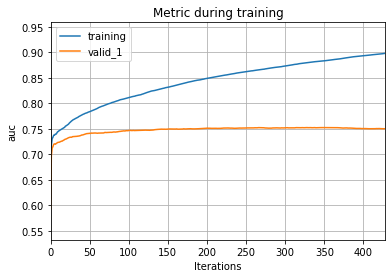

In [114]:
lgb.plot_metric(model, metric='auc')

## Prepare test

In [111]:
test = preproc(test)

In [112]:
test['dep_delayed_15min'] = model.predict_proba(test)[:, 1]

In [113]:
test['dep_delayed_15min'].to_csv(data_path.joinpath('submit.csv'), index_label='id')

# Next Steps

* Grid Search through params
* datetime engineering (sin/cos transform, DepTime limits transform(?))

# Notes

* OHE sucks since model just doesn't use those features
* there are only 1 after 2400

__Best Score__: 0.72329